<a href="https://colab.research.google.com/github/yerzhanimanmalik/Neuroml/blob/master/Imanmalik_NEUROML2020_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuroml Project

### Yerzhan Imanmalik


* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/), [sklearn](https://scikit-learn.org/stable/) and [pytorch](https://pytorch.org/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` and `pytorch` libraries, as well as ready **NN BUILDING BLOCKS** from `pytorch.nn` module, instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE SCORES**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
os.environ["COMET_DISABLE_AUTO_LOGGING"] = '1'

In [2]:
!pip install --quiet --upgrade comet_ml
# import comet_ml in the top of your file
from comet_ml import Experiment

# Create an experiment with your api key:
experiment = Experiment(
    api_key="4F0ZxgV9HxwDkyS2I8hKpYu2F",
    project_name="vae-clusterization",
    workspace="imanmal1k",
)
experiment.set_name('Azure: batchsize = 2')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/imanmal1k/vae-clusterization/41466b8baedc401a94e0a6606fa2c35d



In [3]:
import os
import time
from tqdm import tqdm
import nibabel as nib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

!pip install nilearn
import nibabel as nib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image

In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 0

Torch version: 1.4.0
Using GPU


### Accessing data in Azure blob


In [5]:
import azureml.core
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()

blob_datastore_name='azblobsdk' # Name of the datastore to workspace
container_name=os.getenv("BLOB_CONTAINER", "neuromlcontainer") # Name of Azure blob container
account_name=os.getenv("BLOB_ACCOUNTNAME", "neuromlstorage") # Storage account name
account_key=os.getenv("BLOB_ACCOUNT_KEY", "WlKg6m1RsuC1XBzvgYQenybBB/iOD9jXVhwpwgCvmHdil31bNBpNzEfQ+yU2yHmNl2W5GVqkjOoYcGzvo89hCg==") # Storage account access key

blob_datastore = Datastore.register_azure_blob_container(workspace=ws, 
                                                         datastore_name=blob_datastore_name, 
                                                         container_name=container_name, 
                                                         account_name=account_name,
                                                         account_key=account_key)

In [6]:
# create a FileDataset pointing to files in 'fs_segmentation' folder and its subfolders recursively
from azureml.core import Dataset

datastore_task = [(blob_datastore, 'la5_task')]
images_task = Dataset.File.from_files(path=datastore_task)

datastore_rest = [(blob_datastore, 'la5_rest')]
images_rest = Dataset.File.from_files(path=datastore_rest)

In [7]:
import tempfile
task_dir = tempfile.mkdtemp()
rest_dir = tempfile.mkdtemp()

context = images_task.mount(task_dir)
context.start()

context2 = images_rest.mount(rest_dir)
context2.start()

### Dataloader to load full-size fMRI task and rest data. 

In [8]:
def load_nii_to_array(nii_path):
    return np.asanyarray(nib.load(nii_path).dataobj)

class fMRIDataset(data.Dataset):
    
    def __init__(self, task_folder_path, rest_folder_path):

         self.task_folder_path = task_folder_path
         self.rest_folder_path = rest_folder_path 

        
    def __getitem__(self, i):
      if i<267*20:
        file_num = i // 267
        timestamp_num = i % 267
        file = os.listdir(self.task_folder_path)[file_num]
        im = image.load_img(self.task_folder_path+'/'+file)
        item = torch.Tensor(np.array(im.dataobj))[..., timestamp_num]
        #item = load_nii_to_array(task_folder_path+'/'+file)
        target = 1
      else:
        i -= 267*20
        file_num = i // 152
        timestamp_num = i % 152
        file = os.listdir(self.rest_folder_path)[file_num]
        im = image.load_img(self.rest_folder_path+'/'+file)
        item = torch.Tensor(np.array(im.dataobj))[..., timestamp_num]
        #item = load_nii_to_array(rest_folder_path+'/'+file)[]
        target = 0
      return item[1:, 6:-7, 1:][None, ...], target 

    def __len__(self):
        return (267+152)*20

In [9]:
# transforms
import warnings

class ToTensor(object):
    def __call__(self, img):
        return torch.FloatTensor(img)

### Load data

In [10]:
# create the dataset and load fMRI sequences

task_folder_path = task_dir
rest_folder_path = rest_dir

transform = transforms.Compose([
    ToTensor(),
])

dataset = fMRIDataset(
    task_folder_path, 
    rest_folder_path
)    

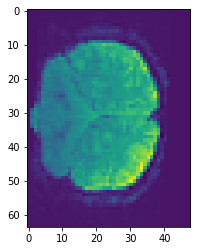

In [11]:
plt.imshow(dataset[0][0][0, :, 20, :])

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_idx, val_idx = train_test_split(np.arange(len(dataset)),
                                      test_size=0.2, random_state=42)
batch_size = 2
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)         #  <--- LOOK HERE
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

In [14]:
dataset[100][0].shape

torch.Size([1, 64, 64, 48])

### Autoencoder

In [15]:
# implement Autoencoder model
# for 64 64 48

class Autoencoder3d(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

        ### YOUR CODE HERE
        
        self.encoder = nn.Sequential(
                nn.Conv3d(1, 32, 4, 2, 1, bias=False),
                nn.BatchNorm3d(32),
                nn.ReLU(inplace=True),
                nn.Conv3d(32, 64, 4, 2, 1, bias=False),
                nn.BatchNorm3d(64),
                nn.ReLU(inplace=True),
                nn.Conv3d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm3d(128),
                nn.ReLU(inplace=True),
                nn.Conv3d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm3d(256),
                nn.ReLU(inplace=True),
                #nn.AdaptiveAvgPool3d(1)
        )
        self.decoder = nn.Sequential(
                nn.ConvTranspose3d(256, 128, 4, 2, 1, bias=False),
                nn.ReLU(inplace=True),
                nn.ConvTranspose3d(128, 64, 4, 2, 1, bias=False),
                nn.ReLU(inplace=True),
                nn.ConvTranspose3d(64, 32, 4, 2, 1, bias=False),
                nn.ReLU(inplace=True),
                nn.ConvTranspose3d(32, 1, 4, 2, 1, bias=False),
                nn.ReLU(inplace=True),
        )    
        
    def encode(self, x):
        z = self.encoder(x) 
        return z
    
    def decode(self, z):
        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x): 
        z = self.encode(x)
        x_rec = self.decode(z)
        return x_rec, z

In [16]:
# implement all needed train functions & train autoencoder

model = Autoencoder3d()
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10
train_loss = np.zeros((num_epochs, 1), dtype=float)
val_loss = np.zeros((num_epochs, 1), dtype=float)

# Train the model

for epoch in range(num_epochs):
    train_loss_list = []
    model.train(True)
    for i, (inputs_batch, targets_batch) in tqdm(enumerate(train_loader)):
        # Run the forward pass
        outputs, z = model(inputs_batch)
        #print(outputs.shape)
        #print(inputs_batch.shape)
        loss = criterion(outputs, inputs_batch)
        train_loss_list.append(loss.item())
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i==100:
          break

    train_loss[epoch] = np.mean(train_loss_list)
    if (i + 1) % 1 == 0:
      print('Epoch [{}/{}], Train loss: {:.4f}'.format(epoch + 1, num_epochs, float(train_loss[epoch])))
      experiment.log_metric("train_loss", train_loss[epoch].item())

    val_loss_list = []
    model.eval()
    for i, (inputs_batch, targets_batch) in tqdm(enumerate(val_loader)):
        outputs, z = model(inputs_batch)
        #print(outputs.shape)
        #print(inputs_batch.shape)
        loss = criterion(outputs, inputs_batch)
        val_loss_list.append(loss.item())

        if i==100:
          break

    val_loss[epoch] = np.mean(val_loss_list)
    if (i + 1) % 1 == 0:
      print('Epoch [{}/{}], Val loss: {:.4f}'.format(epoch + 1, num_epochs, float(val_loss[epoch])))
      experiment.log_metric("val_loss", val_loss[epoch].item())

100it [08:39,  5.20s/it]
100it [08:07,  4.87s/it]
100it [08:42,  5.22s/it]
100it [08:01,  4.82s/it]
100it [08:25,  5.05s/it]
100it [08:00,  4.80s/it]
100it [08:32,  5.12s/it]
53it [04:10,  4.40s/it]

Epoch [1/10], Train loss: 107494.6737
Epoch [1/10], Val loss: 23196.3914
Epoch [2/10], Train loss: 13036.7142
Epoch [2/10], Val loss: 10511.1604
Epoch [3/10], Train loss: 10709.4709
Epoch [3/10], Val loss: 10156.6764
Epoch [4/10], Train loss: 9238.3060


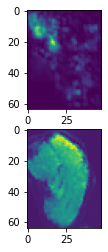

In [37]:
model.eval()
with torch.no_grad():
  outputs, z = model(inputs_batch)
  plt.figure()
  plt.subplot(2, 1, 1)
  plt.imshow(outputs[0, 0, 30])

  plt.subplot(2, 1, 2)
  plt.imshow(inputs_batch[0, 0, 30])

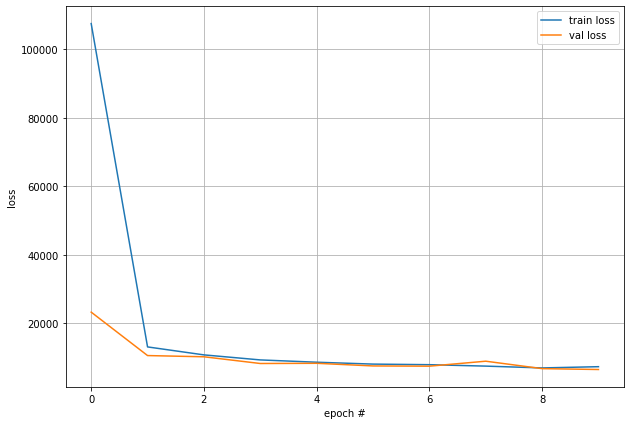

In [38]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, label = "train loss")
plt.plot(val_loss, label = "val loss")
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.legend()
plt.grid()

In [39]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(self.__class__, self).__init__()

        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12288, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x): 
        z = self.encoder(x)
        y = self.classifier(z)
        return y

In [40]:
model_clf = Classifier(model.encoder)
criterion=nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_clf.parameters(), lr=1e-2)
num_epochs = 10
train_loss_clf = np.zeros((num_epochs, 1), dtype=float)
val_loss_clf = np.zeros((num_epochs, 1), dtype=float)

# Train the model

for epoch in range(num_epochs):
    train_loss_clf_list = []
    model_clf.train(True)
    for i, (inputs_batch, targets_batch) in tqdm(enumerate(train_loader)):
        # Run the forward pass
        outputs = model_clf(inputs_batch)
        #print(outputs.shape)
        #print(inputs_batch.shape)
        loss = criterion(outputs.view(-1), targets_batch.view(-1).type(torch.FloatTensor))
        train_loss_clf_list.append(loss.item())
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i==100:
          break

    train_loss_clf[epoch] = np.mean(train_loss_clf_list)
    if (i + 1) % 1 == 0:
      print('Epoch [{}/{}], Train loss: {:.4f}'.format(epoch + 1, num_epochs, float(train_loss_clf[epoch])))
      experiment.log_metric("train_loss_clf", train_loss_clf[epoch].item())

    val_loss_clf_list = []
    model_clf.eval()
    for i, (inputs_batch, targets_batch) in tqdm(enumerate(val_loader)):
        outputs = model_clf(inputs_batch)
        #print(outputs.shape)
        #print(inputs_batch.shape)
        loss = criterion(outputs.view(-1), targets_batch.view(-1).type(torch.FloatTensor))
        val_loss_clf_list.append(loss.item())

        if i==100:
          break

    val_loss_clf[epoch] = np.mean(val_loss_clf_list)
    if (i + 1) % 1 == 0:
      print('Epoch [{}/{}], Val loss: {:.4f}'.format(epoch + 1, num_epochs, float(val_loss_clf[epoch])))
      experiment.log_metric("val_loss_clf", val_loss_clf[epoch].item())

100it [08:25,  5.05s/it]
100it [08:02,  4.83s/it]
62it [05:08,  4.82s/it]

Epoch [1/10], Train loss: 0.6839
Epoch [1/10], Val loss: 0.6794


In [41]:
val_loss_clf_list = []
val_acc_clf_list = []
model_clf.eval()
for i, (inputs_batch, targets_batch) in tqdm(enumerate(val_loader)):
    outputs = model_clf(inputs_batch)
    #print(outputs.shape)
    #print(inputs_batch.shape)
    loss = criterion(outputs.view(-1), targets_batch.view(-1).type(torch.FloatTensor))
    acc = ((outputs.view(-1) > 0.5) == targets_batch.view(-1).type(torch.FloatTensor)).type(torch.FloatTensor).mean()
    val_loss_clf_list.append(loss.item())
    val_acc_clf_list.append(acc.item())


280it [22:18,  5.34s/it]

In [ ]:
np.mean(val_acc_clf_list)

### Check

In [ ]:
import os

for file in os.listdir(task_folder_path):
  print(file)

In [ ]:
!pip install nilearn
import nibabel as nib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image

In [ ]:
  file_num = i // 267
  timestamp_num = i % 267
  file = os.listdir(task_folder_path)[file_num]
  im = image.load_img(task_folder_path+'/'+file)
  resampled1 = torch.Tensor(np.array(im.dataobj))[..., timestamp_num] 


In [ ]:
for file in os.listdir(task_folder_path)[2:]:
  im = image.load_img(task_folder_path+'/'+file)
  resampled1 = torch.Tensor(np.array(im.dataobj)).permute(3,0,1,2)  # dataloader
  print(resampled1.shape)
  print(type(resampled1))
  break

In [ ]:
for file in os.listdir(rest_folder_path):
  im = image.load_img(rest_folder_path+'/'+file)
  resampled = torch.Tensor(np.array(im.dataobj))
  print(resampled.permute(3, 0, 1, 2).shape)
  print(type(resampled))
  break

In [ ]:
from IPython.display import clear_output

In [ ]:
 for i in range(65):
  clear_output(True)
  plt.figure()
  plt.imshow(resampled1[128, i])
  plt.show()